In [18]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder.appName("Linear Regression")
         .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
         .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
         .getOrCreate())

In [19]:
data = spark.read.csv('data/single_variable_regression.csv', header=True, inferSchema=True)

In [20]:
len(data.columns)

2

In [21]:
data.count()

10

In [22]:
data.show()

+----------+----------+
|house_size|price_sold|
+----------+----------+
|      1490|    600000|
|      2500|    950000|
|      1200|    550000|
|       900|    450000|
|      1300|    560000|
|      1000|    500000|
|       850|    430000|
|       750|    400000|
|      2000|    800000|
|      1600|    700000|
+----------+----------+



In [23]:
from pyspark.ml.feature import VectorAssembler

In [24]:
assembler_object = VectorAssembler(inputCols=['house_size'], outputCol='house_size_vector')

In [25]:
feature_vector_df = assembler_object.transform(data)

In [26]:
feature_vector_df.show()

+----------+----------+-----------------+
|house_size|price_sold|house_size_vector|
+----------+----------+-----------------+
|      1490|    600000|         [1490.0]|
|      2500|    950000|         [2500.0]|
|      1200|    550000|         [1200.0]|
|       900|    450000|          [900.0]|
|      1300|    560000|         [1300.0]|
|      1000|    500000|         [1000.0]|
|       850|    430000|          [850.0]|
|       750|    400000|          [750.0]|
|      2000|    800000|         [2000.0]|
|      1600|    700000|         [1600.0]|
+----------+----------+-----------------+



In [27]:
feature_vector_df.printSchema()

root
 |-- house_size: integer (nullable = true)
 |-- price_sold: integer (nullable = true)
 |-- house_size_vector: vector (nullable = true)



In [28]:
formatted_data = feature_vector_df.select('house_size_vector', 'price_sold')

In [29]:
train_data, test_data = formatted_data.randomSplit([0.7, 0.3])

In [30]:
from pyspark.ml.regression import LinearRegression

linear_reg = LinearRegression(
    featuresCol='house_size_vector', 
    labelCol='price_sold'
)

In [31]:
linear_reg_model = linear_reg.fit(train_data)

In [32]:
test_results = linear_reg_model.evaluate(test_data)

In [33]:
test_results.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -4679.750021208194|
|-420.77878008049447|
|-4133.6990639945725|
+-------------------+



In [36]:
linear_reg_model.predict(test_data)

AttributeError: 'LinearRegressionSummary' object has no attribute 'show'

In [37]:
test_results.rootMeanSquaredError

3613.1511175350215

In [38]:
test_results.r2

0.9997743975633961

In [39]:
unlabelled_data = test_data.select('house_size_vector')

In [40]:
prediction = linear_reg_model.transform(unlabelled_data)

In [41]:
prediction.show()

+-----------------+-----------------+
|house_size_vector|       prediction|
+-----------------+-----------------+
|          [850.0]|434679.7500212082|
|          [900.0]|450420.7787800805|
|         [2500.0]|954133.6990639946|
+-----------------+-----------------+



In [42]:
w = linear_reg_model.coefficients[0]

In [43]:
w

314.8205751774463

In [44]:
b = linear_reg_model.intercept

In [45]:
b

167082.26112037883

In [46]:
# What is the price of the new house if it's size is 1511sqft
new_house_size = 1511
new_house_price = (w * 1511) + b

In [47]:
new_house_price

642776.1502135001

In [48]:
import matplotlib.pyplot as plt

data_plot = data.toPandas()

In [49]:
data_plot

,house_size,price_sold
0,1490,600000
1,2500,950000
2,1200,550000
3,900,450000
4,1300,560000
5,1000,500000
6,850,430000
7,750,400000
8,2000,800000
9,1600,700000


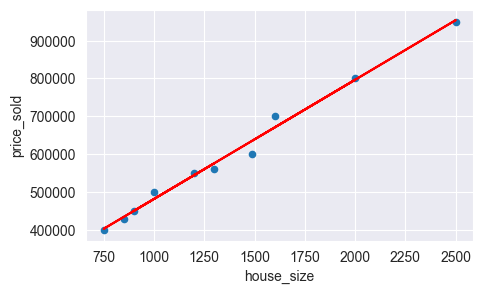

In [50]:
data_plot.plot.scatter(x='house_size', y='price_sold', figsize=(5, 3))

x = data_plot.iloc[:, 0]
y = w*x + b

plt.plot(x, y, 'r')

In [53]:
data = spark.read.csv('data/multi_variable_regression.csv', header=True, inferSchema=True)

In [54]:
data.show()

+----------+--------+------+---------+--------------+----------+
|house_size|bedrooms|floors|house_age|          area|price_sold|
+----------+--------+------+---------+--------------+----------+
|      1490|       2|     2|       10|    Ave Avenue|    600000|
|      2500|       3|     2|       20|    Ave Avenue|    950000|
|      1200|       2|     1|        5|       MG Road|    550000|
|       900|       2|     2|       15|       MG Road|    450000|
|      1350|       2|     2|        5|Dollors Colony|    650000|
|      1000|       2|     1|        2|Dollors Colony|    600000|
|       850|       1|     1|        5|   Wall Street|    400000|
|       750|       1|     1|        1|   Wall Street|    400000|
|      2000|       3|     1|        2|    Ave Avenue|    850000|
|      1600|       2|     1|       20|       MG Road|    650000|
+----------+--------+------+---------+--------------+----------+



In [55]:
data.printSchema()

root
 |-- house_size: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- house_age: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- price_sold: integer (nullable = true)



In [56]:
from pyspark.ml.feature import StringIndexer

In [57]:
string_index_obj = StringIndexer(inputCol='area', outputCol='area_feature')

In [58]:
string_index_df_obj = string_index_obj.fit(data)
final_data = string_index_df_obj.transform(data)

In [59]:
final_data.show()

+----------+--------+------+---------+--------------+----------+------------+
|house_size|bedrooms|floors|house_age|          area|price_sold|area_feature|
+----------+--------+------+---------+--------------+----------+------------+
|      1490|       2|     2|       10|    Ave Avenue|    600000|         0.0|
|      2500|       3|     2|       20|    Ave Avenue|    950000|         0.0|
|      1200|       2|     1|        5|       MG Road|    550000|         1.0|
|       900|       2|     2|       15|       MG Road|    450000|         1.0|
|      1350|       2|     2|        5|Dollors Colony|    650000|         2.0|
|      1000|       2|     1|        2|Dollors Colony|    600000|         2.0|
|       850|       1|     1|        5|   Wall Street|    400000|         3.0|
|       750|       1|     1|        1|   Wall Street|    400000|         3.0|
|      2000|       3|     1|        2|    Ave Avenue|    850000|         0.0|
|      1600|       2|     1|       20|       MG Road|    650000|

In [60]:
assembler_object = VectorAssembler(
    inputCols=['house_size', 'bedrooms', 'floors', 'house_age', 'area_feature'],
    outputCol='features'
)

In [61]:
feature_vector_df = assembler_object.transform(dataset=final_data)

In [62]:
feature_vector_df.show(truncate=False)

+----------+--------+------+---------+--------------+----------+------------+-------------------------+
|house_size|bedrooms|floors|house_age|area          |price_sold|area_feature|features                 |
+----------+--------+------+---------+--------------+----------+------------+-------------------------+
|1490      |2       |2     |10       |Ave Avenue    |600000    |0.0         |[1490.0,2.0,2.0,10.0,0.0]|
|2500      |3       |2     |20       |Ave Avenue    |950000    |0.0         |[2500.0,3.0,2.0,20.0,0.0]|
|1200      |2       |1     |5        |MG Road       |550000    |1.0         |[1200.0,2.0,1.0,5.0,1.0] |
|900       |2       |2     |15       |MG Road       |450000    |1.0         |[900.0,2.0,2.0,15.0,1.0] |
|1350      |2       |2     |5        |Dollors Colony|650000    |2.0         |[1350.0,2.0,2.0,5.0,2.0] |
|1000      |2       |1     |2        |Dollors Colony|600000    |2.0         |[1000.0,2.0,1.0,2.0,2.0] |
|850       |1       |1     |5        |Wall Street   |400000    |

In [63]:
df = feature_vector_df.select('features', 'price_sold')

In [64]:
train_df, test_df = df.randomSplit(weights=[0.7, 0.3])

lr = LinearRegression(
    featuresCol='features',
    labelCol='price_sold'
)

model = lr.fit(train_df)

In [65]:
result = model.evaluate(test_df)
result.r2

-523.312671614252

In [66]:
# What will be the price for a house with the following features:
# size = 1742
# beds = 3
# floors = 1
# age = 10
# area = 2

In [67]:
model.coefficients

DenseVector([4000.0, -149999.9999, 2099999.9997, -100000.0, 549999.9999])

In [68]:
# Task - loading the tips dataset, create a model to predict the total bill. Use all features except the total bill to train your model
# What is the performance of your model (r^2)

import seaborn as sns

df_tips = sns.load_dataset('tips')
df = spark.createDataFrame(df_tips)

df.show()

Py4JJavaError: An error occurred while calling o1208.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 38.0 failed 1 times, most recent failure: Lost task 0.0 in stage 38.0 (TID 35) (Samson executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1575)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:694)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:659)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:635)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:581)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:540)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1575)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:694)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:659)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:635)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:581)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:540)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more
